# Wrangle Tip Data
<p>Wrangling Tips is pretty simple, we are only concerned with tips given to businesses that are Arizona Restaurants so the first step is to only keep tips from the source tip.json file that are for businesses that we cleaned in the Business Data Wrangling Notebook.</p>
    
<p>Next we are trying to preserve as much information as possible when cleaning tip text so we are only removing commas.  Finally, after inspecting the length of tips, we are keeping only tips with 5 or more characters.  This 5 character limit reduces the 119274 tips to a subset of 118301 tips.</p>

<p>The 5 Character cut off is used after an inspection into length of the shortest 5% quantile tip text length year over year.  The 5% quantile rarely drops below 10 characters in any subset of tips by date, restaurant, or fast_food type</p>

## Step 0: Import packages and establish chart output standards

In [1]:
import numpy as np
import pandas as pd
import datetime
import json

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)

DO_WRITE_CHARTS = True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.lower()))

# Step 1: Load Cleaned Business Data
<p>Load cleaned Arizona Restaurant Data from csv file and extract `business_id` values.  Load tips and keep only those given to these Arizona Restaurants</p>

In [3]:
restaurant_data = pd.read_csv('../clean_data/az_restaurant_business_clean.csv', index_col=0)
restaurant_bids = restaurant_data.business_id.values
time_marker('{:d} Restaurant business_id values'.format(len(restaurant_bids)))

[00:54:59.058621] 7066 restaurant business_id values


In [4]:
restaurant_data.head(3)

,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food
0,1WBkAuQg81kokZIPMpn9Zg,"['burgers', 'restaurants']",Phoenix,1,Charr An American Burger Bar,85022.0,232,3.0,0
1,kKx8iCJkomVQBdWHnmmOiA,"['restaurants', 'pizza']",Mesa,1,Little Caesars Pizza,85209.0,4,2.5,0
2,VdlPZg2NAu8t8GkdbPLecg,"['restaurants', 'gluten-free', 'indian', 'seaf...",Scottsdale,1,Tandoori Times Indian Bistro,85258.0,263,3.5,0


# Step 2: Load Tip Data for All Arizona Restaurants
<p><b>WARNING: Loading Tips takes roughly 7 minutes</b></p>

In [5]:
all_restaurant_tips = []

source_data_file = '../source_data/tip.json'

# read the file line by line and save only lines we need
with open(source_data_file, 'r') as tip_file:
    for i, tip_json in enumerate(tip_file):
        tip = json.loads(tip_json)

        # append to restaurant tips
        if tip['business_id'] in restaurant_bids:
            all_restaurant_tips.append(tip)
            
        if i % 100000 == 0 and i != 0:
            time_marker('\tfound {:>7}/{:>7} Tips so far {:2.4f} '.format(str(len(all_restaurant_tips)),str(i),
                                                                                 len(all_restaurant_tips)/(i+1)*100.))
        
print('Selected {:d} Arizona Restaurant tips from {:d} total tips'.format(len(all_restaurant_tips), i))
tips_df = pd.DataFrame(all_restaurant_tips)

[00:55:33.267604] 	found    1419/ 100000 tips so far 1.4190 
[00:56:09.696969] 	found   27057/ 200000 tips so far 13.5284 
[00:56:49.588343] 	found   56452/ 300000 tips so far 18.8173 
[00:57:31.608900] 	found   77230/ 400000 tips so far 19.3075 
[00:58:08.335371] 	found   77358/ 500000 tips so far 15.4716 
[00:58:42.238586] 	found   77675/ 600000 tips so far 12.9458 
[00:59:17.689771] 	found   89079/ 700000 tips so far 12.7256 
[00:59:54.261493] 	found   99787/ 800000 tips so far 12.4734 
[01:00:28.384729] 	found  101028/ 900000 tips so far 11.2253 
[01:00:58.457960] 	found  110263/1000000 tips so far 11.0263 
Selected 119274 Arizona Restaurant tips from 1098324 total tips


In [6]:
tips_df.head(3)

,business_id,date,likes,text,user_id
0,xFN8mRubo3G0oIzJwc8XBA,2012-03-28,0,"Finally, found some churros. Four types here. ...",TvkqJ8YEIsTb16RnnrNyfQ
1,Xmndl6GoZg8taEUlwQMYxg,2012-03-28,0,closed closed closed closed closed closed clos...,TvkqJ8YEIsTb16RnnrNyfQ
2,1CqDdPrrb0xvQpgu7fhI5w,2012-03-27,0,Great weather for eating outdoors. Good service.,TvkqJ8YEIsTb16RnnrNyfQ


# Step 3: Merge `fast_food_indicator` to tip records

In [7]:
# extract business ids for fast food locations
fast_food_indicator = restaurant_data[['business_id', 'is_fast_food']].copy()

# append is_fast_food to tips
tips_df = tips_df.merge(fast_food_indicator, on='business_id', how='left')

# Step 4: Sanitize Tip Text for CSV
<p>For now, to retain as much information as possible, just remove commas from tip text.</p>

In [8]:
tips_df['text'] = tips_df.text.apply(lambda x: x.replace(',', '').lower())
tips_df['tip_len'] = tips_df.text.str.len()

In [9]:
tips_df.head(3)

,business_id,date,likes,text,user_id,is_fast_food,tip_len
0,xFN8mRubo3G0oIzJwc8XBA,2012-03-28,0,finally found some churros. four types here. i...,TvkqJ8YEIsTb16RnnrNyfQ,0,64
1,Xmndl6GoZg8taEUlwQMYxg,2012-03-28,0,closed closed closed closed closed closed clos...,TvkqJ8YEIsTb16RnnrNyfQ,0,139
2,1CqDdPrrb0xvQpgu7fhI5w,2012-03-27,0,great weather for eating outdoors. good service.,TvkqJ8YEIsTb16RnnrNyfQ,0,48


# Step 5: Set Column data types

In [10]:
tips_df['date'] = pd.to_datetime(tips_df['date'])

tips_df['business_id'] = tips_df['business_id'].astype('str')
tips_df['text'] = tips_df['text'].astype('str')
tips_df['user_id'] = tips_df['user_id'].astype('str')

tips_df['likes'] = tips_df['likes'].astype('int')
tips_df['tip_len'] = tips_df['tip_len'].astype('int')
tips_df['is_fast_food'] = tips_df['is_fast_food'].astype('int')

In [11]:
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119274 entries, 0 to 119273
Data columns (total 7 columns):
business_id     119274 non-null object
date            119274 non-null datetime64[ns]
likes           119274 non-null int64
text            119274 non-null object
user_id         119274 non-null object
is_fast_food    119274 non-null int64
tip_len         119274 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 7.3+ MB


# Step 6: Pruning Short Tips
<p>The 5 Character cut off is used after an inspection into length of the shortest 5% quantile tip text length year over year.  The 5% quantile rarely drops below 10 charcters in any subset of tips by date, restaurant, or fast_food type</p>

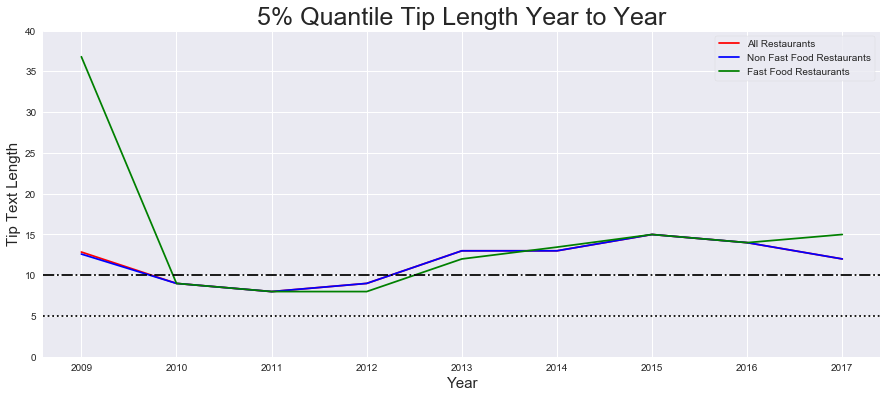

In [12]:
nff_tips_df = tips_df[tips_df.is_fast_food == 0].copy()
ff_tips_df = tips_df[tips_df.is_fast_food == 1].copy()

quant = 0.05

ax = tips_df.groupby([tips_df.date.dt.year]).quantile(quant)['tip_len'].plot(figsize=FIG_SIZE, color='r')
nff_tips_df.groupby([nff_tips_df.date.dt.year]).quantile(quant)['tip_len'].plot(ax=ax, color='b')
ff_tips_df.groupby([ff_tips_df.date.dt.year]).quantile(quant)['tip_len'].plot(ax=ax, color='g')

ax.set_title('5% Quantile Tip Length Year to Year', size=TITLE_FONT_SIZE)
ax.set_xlabel('Year', size=LABEL_FONT_SIZE)
ax.set_ylabel('Tip Text Length', size=LABEL_FONT_SIZE)

ax.axhline(5, linestyle=':', color='k')
ax.axhline(10, linestyle='-.', color='k')

ax.set_ylim([0, 40])

ax.legend(['All Restaurants', 'Non Fast Food Restaurants', 'Fast Food Restaurants'], loc=1, frameon=True)

if DO_WRITE_CHARTS:
        plt.savefig('../charts/tip_length_Q05_yearly.png')
plt.show()
plt.close()

In [13]:
min_tip_len = 5
tips_df_count = tips_df.shape[0]
tips_df = tips_df[tips_df.tip_len >= min_tip_len].copy()
tips_df.reset_index(inplace=True, drop=True)
print('Reduced {:d} tips to a subset of {:d} tips {:2.4f} [tips_df]'.format(tips_df_count,
                                                                               tips_df.shape[0], 
                                                                               (100.*tips_df.shape[0]/tips_df_count)))

Reduced 119274 tips to a subset of 118301 tips 99.1842 [tips_df]


In [14]:
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118301 entries, 0 to 118300
Data columns (total 7 columns):
business_id     118301 non-null object
date            118301 non-null datetime64[ns]
likes           118301 non-null int64
text            118301 non-null object
user_id         118301 non-null object
is_fast_food    118301 non-null int64
tip_len         118301 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 6.3+ MB


# Step 7: Write Cleaned Data to File
<p>Write data frame of only Arizona Restaurant tips to file</p>

In [15]:
file_name = '../clean_data/az_restaurant_tips.csv'
time_marker(text='Writing {:d} records to file {}'.format(tips_df.shape[0], file_name))
tips_df.to_csv(file_name, encoding='utf-8')

time_marker('complete!')

[01:01:28.580919] writing 118301 records to file ../clean_data/az_restaurant_tips.csv
[01:01:31.179060] complete!


In [16]:
tips_df.head(3)

,business_id,date,likes,text,user_id,is_fast_food,tip_len
0,xFN8mRubo3G0oIzJwc8XBA,2012-03-28,0,finally found some churros. four types here. i...,TvkqJ8YEIsTb16RnnrNyfQ,0,64
1,Xmndl6GoZg8taEUlwQMYxg,2012-03-28,0,closed closed closed closed closed closed clos...,TvkqJ8YEIsTb16RnnrNyfQ,0,139
2,1CqDdPrrb0xvQpgu7fhI5w,2012-03-27,0,great weather for eating outdoors. good service.,TvkqJ8YEIsTb16RnnrNyfQ,0,48


In [17]:
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118301 entries, 0 to 118300
Data columns (total 7 columns):
business_id     118301 non-null object
date            118301 non-null datetime64[ns]
likes           118301 non-null int64
text            118301 non-null object
user_id         118301 non-null object
is_fast_food    118301 non-null int64
tip_len         118301 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 6.3+ MB
